## Logistic regression with `pymc3`

Logistic regression is one of the simplest statistical models &mdash; and like many things in life, simple here is often synonymous with extremely powerful. I'm interested in the Bayesian statistics approach to it, here using Python. 

Here, let's learn how to do this basic task with `pymc3`, and notice if there are any gotchas worth mentioning.

### A note on `pymc4`
I started off this notebook by first wanting to try out `pymc4` (backed by Tensorflow instead of the deprecated Theano backend), which I thought was still in pre-release at the time. Turns out, development of `pymc4` has halted, and `pymc3` is the new black! That's great news in general, I think.

### Task
I'll be using a [small little dataset from Kaggle called `cycling.csv`](https://www.kaggle.com/dixienewsome/cycling). The plan is as folows:

1. We'll create an extra boolean column called `hr_zone_4` if the average heart rate hit the classic "Zone 4" training, commonly called lactate threshold.
2. Massage the rest of the data to create usable variables for regression
3. Perform the regression using `scipy` for benchmark
4. Perform the regression with `pymc4`!

Notice that our task is not very... important? or interesting? We should just consider it a way to get working data and see if we can detect patterns.

In [51]:
%matplotlib inline
import re

import pandas as pd
import numpy as np
import pymc3 as pm
from IPython.display import display

# How many seconds per HH:MM:SS segment
SECONDS_MAP = {0: 1, 1: 60, 2: 60 * 60}

loc = '~/data/cycling/cycling.csv'
df = pd.read_csv(loc, na_values='--', thousands=',', parse_dates=['Date'])


def clean_timedelta_str(text: str) -> int:
    """Takes in dirty HH:MM:SS, returns seconds"""
    parts = text.replace('.', ':').split(':')
    duration = 0
    for ix, part in enumerate(reversed(parts)):
        duration += SECONDS_MAP[ix] * int(part)
    return float(duration)
        

df['Time'] = df['Time'].apply(clean_timedelta_str)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Activity Type            340 non-null    object        
 1   Date                     340 non-null    datetime64[ns]
 2   Distance                 340 non-null    float64       
 3   Calories                 333 non-null    float64       
 4   Time                     340 non-null    float64       
 5   Avg HR                   311 non-null    float64       
 6   Max HR                   311 non-null    float64       
 7   Avg Speed                331 non-null    float64       
 8   Max Speed                327 non-null    float64       
 9   Elev Gain                198 non-null    float64       
 10  Elev Loss                198 non-null    float64       
 11  Avg Bike Cadence         255 non-null    float64       
 12  Max Bike Cadence         255 non-nul

,Activity Type,Date,Distance,Calories,Time,Avg HR,Max HR,Avg Speed,Max Speed,Elev Gain,Elev Loss,Avg Bike Cadence,Max Bike Cadence,Normalized Power® (NP®),Training Stress Score®,Max Avg Power (20 min),Power,Max Power
0,indoor_cycling,2018-12-03 05:54:00,25.91,696.0,4595.0,164.0,180.0,20.3,23.9,NaN,NaN,89.0,102.0,158.0,66.8,163.0,152.0,404.0
1,road_biking,2018-12-02 13:47:00,20.81,679.0,4872.0,162.0,190.0,15.4,27.2,105.0,89.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,road_biking,2018-11-22 07:44:00,46.22,1158.0,10188.0,158.0,192.0,16.3,26.1,276.0,318.0,83.0,110.0,140.0,116.8,155.0,114.0,592.0
3,indoor_cycling,2018-11-18 08:36:00,23.27,634.0,4734.0,149.0,167.0,17.7,28.1,NaN,NaN,84.0,104.0,143.0,55.9,150.0,134.0,321.0
4,indoor_cycling,2018-11-18 07:29:00,12.21,512.0,3630.0,160.0,188.0,12.1,23.2,NaN,NaN,85.0,109.0,176.0,65.3,189.0,143.0,675.0


<AxesSubplot:>

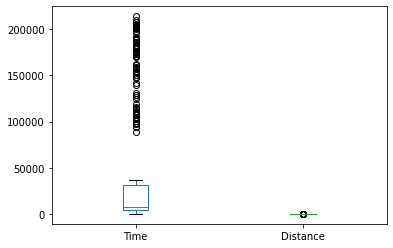

In [61]:
df.plot.box()

## Benchmark – Logistic regression with `scipy`

## Logistic regression with `pymc3`

In [2]:
ata = load_breast_cancer()
X = data["data"].astype('float32')
# Standardize to avoid overflow issues
X -= X.mean(0)
X /= X.std(0)
y = data["target"]

n_samples, n_features = X.shape

X = tf.constant(X)




NameError: name 'load_breast_cancer' is not defined

In [ ]:
@pm4.model
def logistic_model():
    w = yield pm4.Normal("w", np.zeros(n_features, 'float32'), 0.01 * np.ones(n_features, 'float32'))